# Make plots for ATAC only clonal analysis

In [73]:
import pandas as pd
import numpy as np
import scanpy as sc
import sf_utils

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from statannotations.Annotator import Annotator
from sklearn.neighbors import kneighbors_graph

import seaborn as sns
import os

sc.settings.set_figure_params(dpi=80, facecolor='white', fontsize=14, scanpy=True, format='pdf')
sc.set_figure_params(figsize=(5,5))

sc.settings.verbosity=3

In [74]:
atac_tf = sc.read_h5ad("../atac_analysis/output_files/lsk_tf_mtx_umap.h5ad")

In [75]:
#add atac celltype
atac_tf.obs['final_celltype'] = atac_tf.obs['predictedGroup_Un']

#add simplified celltypes
atac_tf.obs['final_celltype_simplified'] = np.array(atac_tf.obs['final_celltype'].values)

#merge all progenitors
atac_tf.obs.loc[atac_tf.obs.final_celltype.isin(["MEP","MPP","MPP/GMP"]),'final_celltype_simplified'] = "Progenitors"

#merge Mast with Ery/Meg
atac_tf.obs.loc[atac_tf.obs.final_celltype.isin(["Mast","Baso/Eos"]),'final_celltype_simplified'] = "Baso/Eos/Mast"

#merge all unknowns
atac_tf.obs.loc[atac_tf.obs.final_celltype.isin(["Unk_1","Unk_2","Unk_3"]),'final_celltype_simplified'] = "Unknown"

# atac_tf.obs.loc[atac_tf.obs.final_celltype.isin(["Lym",'pDC','Ccr7_DC']),'final_celltype_simplified'] = "Lym/DC"

In [76]:
temp=sc.read_h5ad("../clone_coembedding/proc_files/lsk_full_coembed_whole_clones.h5ad")

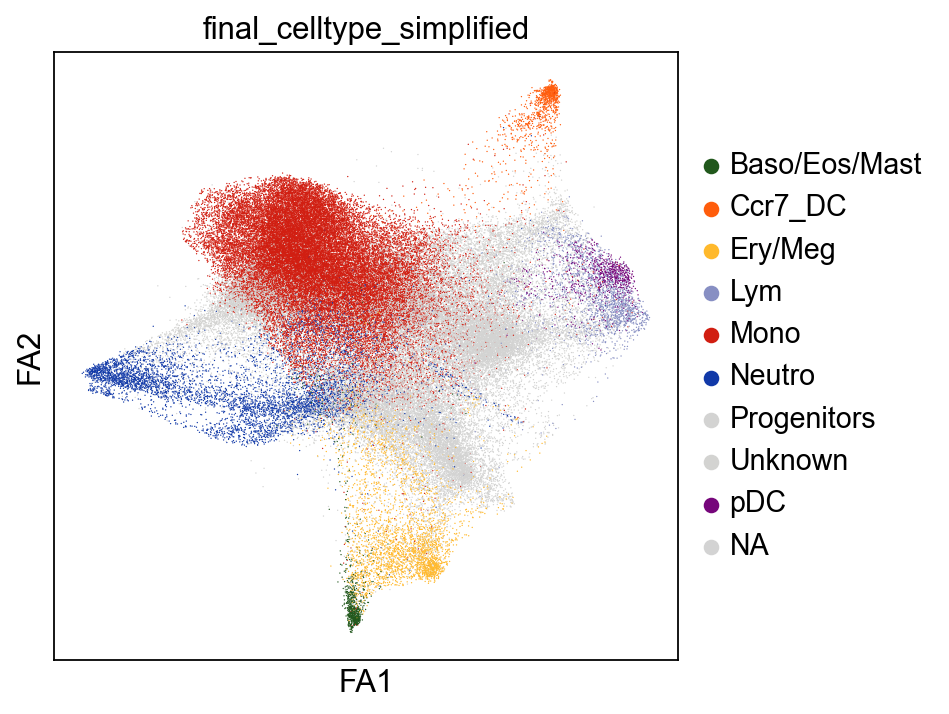

In [77]:
sc.pl.draw_graph(temp,color='final_celltype_simplified')

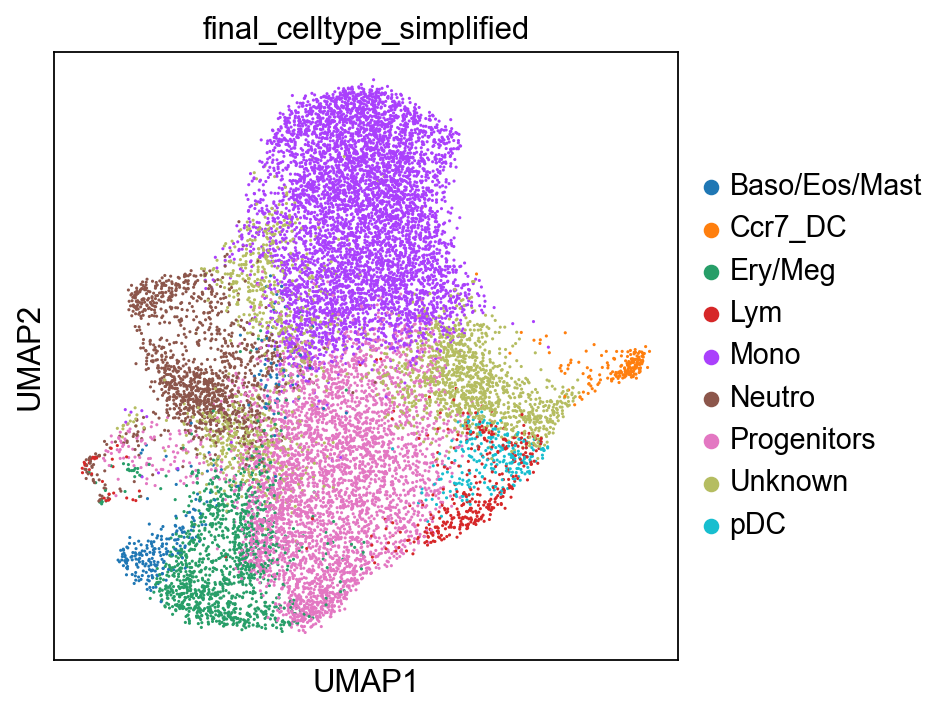

In [78]:
sc.pl.umap(atac_tf, color='final_celltype_simplified')

In [79]:
atac_tf.uns['final_celltype_simplified_colors'] = temp.uns['final_celltype_simplified_colors']

In [80]:
umap_df = pd.DataFrame(data=atac_tf.obsm['X_umap'],
                      index=atac_tf.obs_names,
                      columns=['UMAP_1','UMAP_2']).copy(deep=True)

In [81]:
atac_tf.obsm['X_umap'][:,1] = umap_df.iloc[:,0]
atac_tf.obsm['X_umap'][:,0] = umap_df.iloc[:,1]

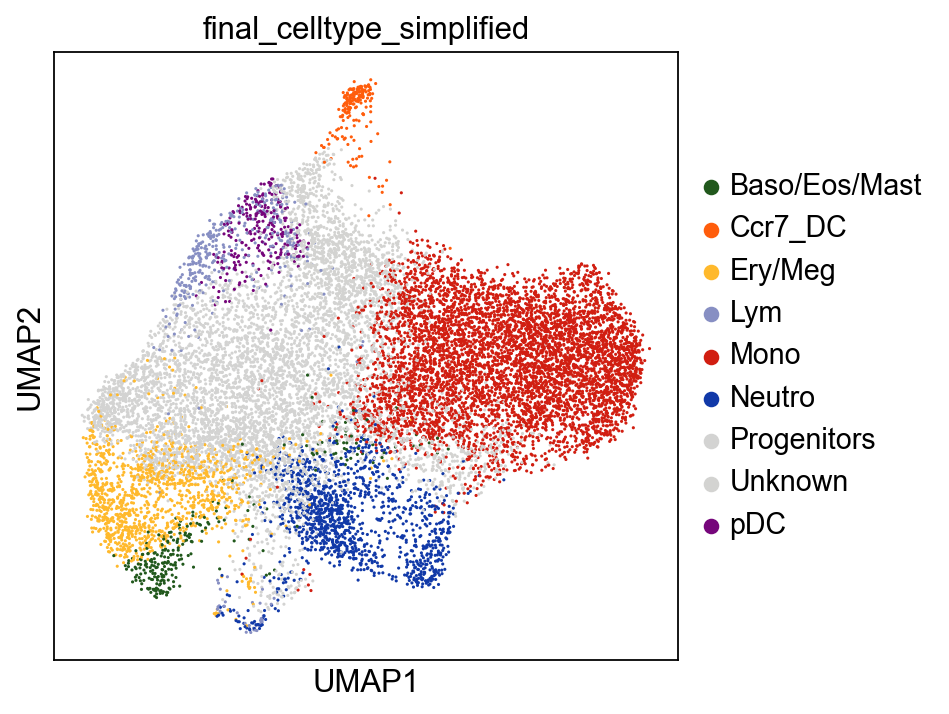

In [82]:
sc.pl.umap(atac_tf, color='final_celltype_simplified')

In [83]:
del temp

In [84]:
# meta = pd.read_csv("../celltag_analysis/input_files/annot_refine/lsk.atac.metadata.csv", index_col=0)
# meta

In [85]:
atac_tf.obs['day'] = atac_tf.obs.index.map(lambda x:x.split("_")[0])

In [89]:
atac_tf.uns['day_colors'][0] = '#ff990c'
atac_tf.uns['day_colors'][1] = '#550000'

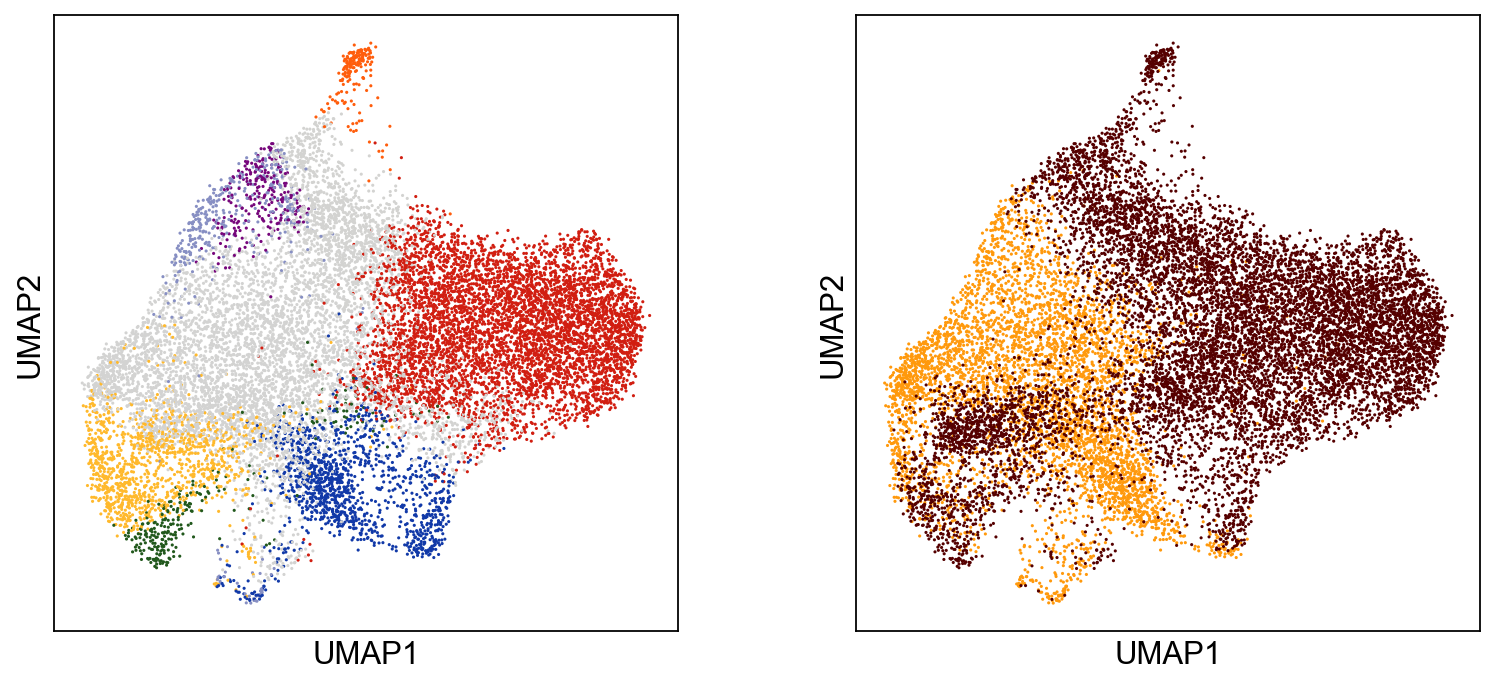

In [93]:
sc.pl.umap(atac_tf, color=['final_celltype_simplified','day'], legend_loc=None, title=["",""])

In [118]:
clones_og = pd.read_csv("../hsc.rna&atac.r1&2_master_v2.csv")
clones_og = clones_og[clones_og['assay']=='atac'].copy()
clones_atac = pd.read_csv("../celltag_analysis/proc_files/clone_table_ATAC_onlylsk_multijac_reanalysis_fate_annot.csv", index_col=0)

In [119]:
clones_og.index = clones_og['cell.bc']
# remove_clones = clones_og['clone.id'].value_counts()[clones_og['clone.id'].value_counts() == 1].index
# clones_og = clones_og[~clones_og['clone.id'].isin(remove_clones)].copy()

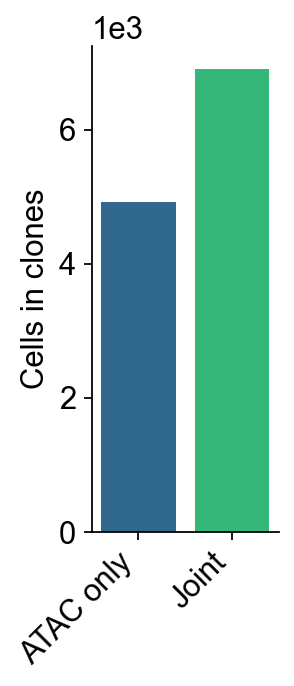

In [120]:
plt.figure(figsize=(1.5,4))
sns.barplot(x = ['ATAC only', 'Joint'],y=[len(clones_atac), len(clones_og)],palette='viridis', saturation=1)
plt.grid(False)
plt.xlabel("")
plt.ylabel("Cells in clones")
plt.xticks(ticks=[0,1], labels=['ATAC only', 'Joint'], rotation=45, ha='right')
# plt.yticks(rotation=0, labels=[1,2,3,4])

ax=plt.gca()
ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)


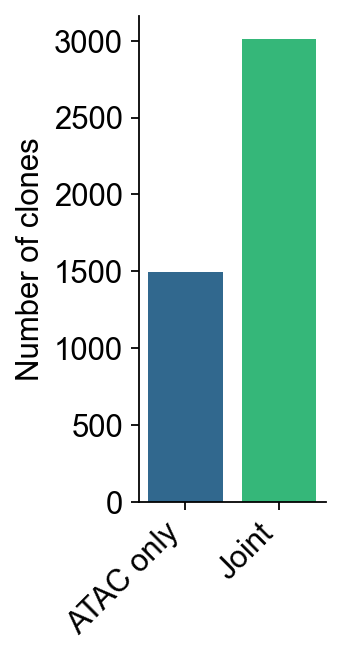

In [121]:
plt.figure(figsize=(1.5,4))
sns.barplot(x = ['ATAC only', 'Joint'],y=[len(clones_atac['clone.id'].unique()), len(clones_og['clone.id'].unique())],palette='viridis', saturation=1)
plt.grid(False)
plt.xlabel("")
plt.ylabel("Number of clones")
plt.xticks(ticks=[0,1], labels=['ATAC only', 'Joint'], rotation=45, ha='right')
# plt.yticks(rotation=0, labels=[1,2,3,4])

ax=plt.gca()
# ax.ticklabel_format(axis="y", style="sci", scilimits=(0,0))
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)

# Rand index

In [158]:
common_cells = set(clones_og['cell.bc'].values).intersection(set(clones_atac['cell.bc.1'].values))
clones_atac_sub = clones_atac[clones_atac['cell.bc.1'].isin(common_cells)].copy()
clones_og_sub = clones_og[clones_og['cell.bc'].isin(common_cells)].copy()

In [159]:
clones_atac_sub = clones_atac_sub.loc[clones_og_sub.index].copy()

In [160]:
from sklearn.metrics import adjusted_rand_score
adjusted_rand_score(clones_og_sub['clone.id'], clones_atac_sub['clone.id'])

0.9887749076349092

# State fate viz

In [161]:
clones_atac.reset_index(inplace=True)
clones_atac.drop(columns="cell.bc.1", inplace=True)

In [162]:
clones_atac.head()

cell.bc  clone.id  edge.den assay day cell_type2  \
0  d2_5-atac-AAACGAAGTATATGGA-1         1       1.0  atac  d2     Neutro   
1  d5_1-atac-AAATGAGCACCCTTAC-1         1       1.0  atac  d5       Mono   
2  d2_5-atac-AAACGAAGTTCCGCGA-1         2       1.0  atac  d2    MPP/GMP   
3  d5_3-atac-CTAGCGGAGCAGGAGG-1         2       1.0  atac  d5      Unk_2   
4  d5_4-atac-ATTGTCTCACGCGTTG-1         2       1.0  atac  d5        uns   

    fate  fate_pct  
0   Mono     100.0  
1   Mono     100.0  
2  Unk_2      50.0  
3  Unk_2      50.0  
4  Unk_2      50.0

In [163]:
#merge lymphoids and DCs
atac_tf.obs['final_celltype_simplified'] = np.array(atac_tf.obs['final_celltype_simplified'])
atac_tf.obs.loc[atac_tf.obs.final_celltype.isin(["Lym",'pDC','Ccr7_DC']),'final_celltype_simplified'] = "Lym/DC"

In [164]:
#redo clone fate assignment with new lym fates

clones_atac.loc[clones_atac.cell_type2.isin(['Lym','pDC','Ccr7_DC']), 'cell_type2'] = 'Lym/DC'
clones_atac.drop(columns=['fate','fate_pct'], inplace=True)

def assign_fate(clone_mtx):
    clone_mtx_curr = clone_mtx[clone_mtx['day'] == 'd5'].copy()
    if(len(clone_mtx_curr) == 0):
        clone_mtx['fate'] = 'no_fate_cells'
        clone_mtx['fate_pct'] = 0
    else:
        clone_mtx['fate'] = clone_mtx_curr['cell_type2'].value_counts(dropna=False).sort_index().idxmax()
        clone_mtx['fate_pct'] = 100*clone_mtx_curr['cell_type2'].value_counts(dropna=False).sort_index().max()/len(clone_mtx_curr)
    return clone_mtx


new_table = pd.DataFrame()

for _,i in clones_atac.groupby("clone.id"):
    clone_curr = assign_fate(i).copy()
    new_table = pd.concat((new_table,clone_curr))

In [165]:
clones_atac = new_table.copy()

In [105]:
fates = clones_atac['fate'].unique()
fates = ['Mono', 'Baso/Eos/Mast', 'Neutro', 'Ery/Meg', 'Lym/DC']

umap_df = pd.DataFrame(data=atac_tf.obsm['X_umap'],
                      index=atac_tf.obs_names,
                      columns=['UMAP_1','UMAP_2']).copy(deep=True)

In [114]:
atac_tf.uns['final_celltype_simplified_colors']

array(['#21581c', '#ff5d0c', '#ffb92c', '#878fc3', '#d11e11', '#1139a8',
       '#d3d3d2', '#d3d3d1', '#76067b'], dtype=object)

In [115]:
atac_tf.uns['final_celltype_simplified_colors'] = ['#21581c', '#ffb92c', '#878fc3', '#d11e11', '#1139a8','#d3d3d2', '#d3d3d1']

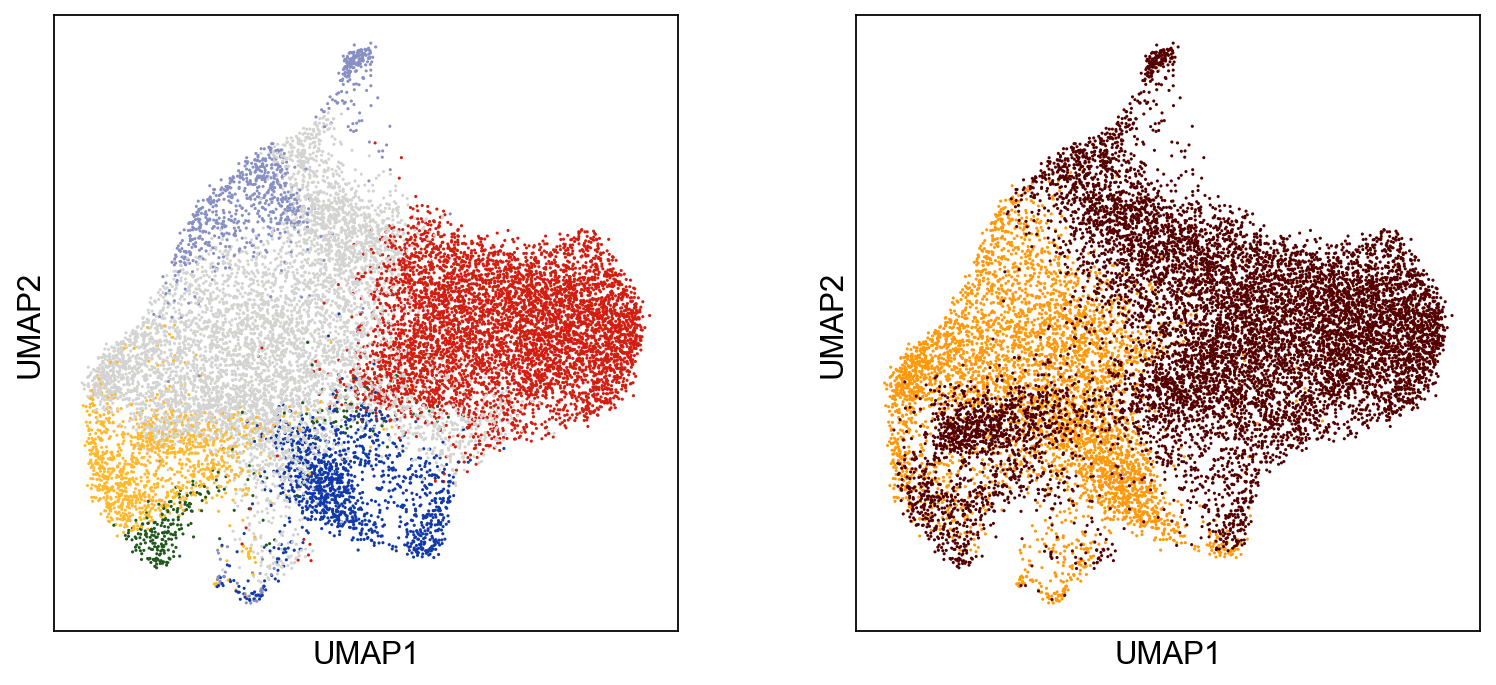

In [166]:
sc.pl.umap(atac_tf, color=['final_celltype_simplified','day'], legend_loc=None, title=["",""])

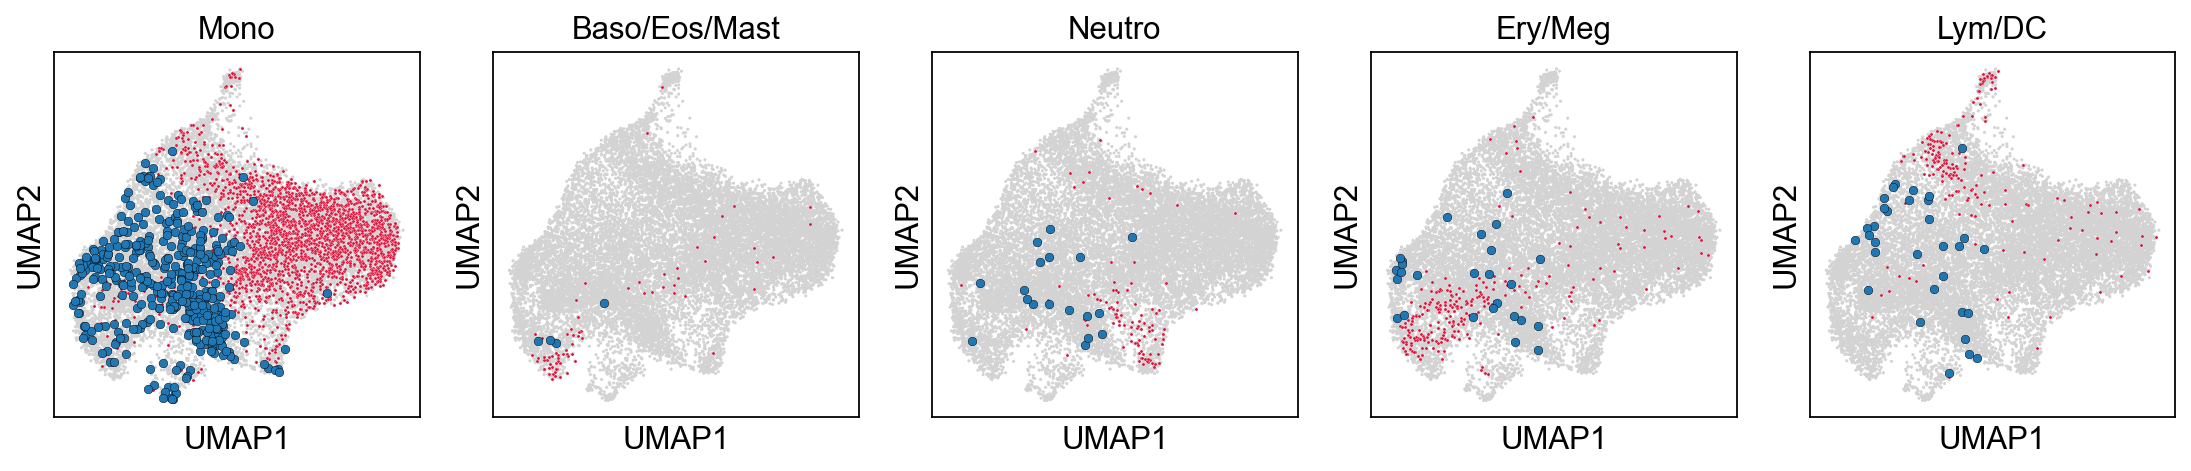

In [171]:
fig = plt.figure(figsize=(17,3))
gs=GridSpec(1,5)

for fate_curr,i in zip(fates,gs):
    
    #subset to cells in state clones for given fate
    clones_atac_curr = clones_atac[(clones_atac['fate']==fate_curr) & (clones_atac['day']=='d2')].copy()
    clones_atac_curr_d5 = clones_atac[(clones_atac['fate']==fate_curr) & (clones_atac['day']=='d5')].copy()
    
    # print(len(clones_atac_curr))
    
    #plot umap
    ax=plt.subplot(i)
    sc.pl.umap(atac_tf,ax=ax,show=False, title=fate_curr)
    # sc.pl.umap(atac_tf, color="final_celltype_simplified", groups=fate_curr, ax=ax, alpha=0.5, show=False, legend_loc=None, title=fate_curr)
    sns.scatterplot(x='UMAP_1', y='UMAP_2', data=umap_df[umap_df.index.isin(clones_atac_curr_d5['cell.bc'])],
                    legend=False, s=2,color='crimson')
    sns.scatterplot(x='UMAP_1', y='UMAP_2', data=umap_df[umap_df.index.isin(clones_atac_curr['cell.bc'])],
                    legend=False, s=15, linewidth=0.2, edgecolor='black')
# plt.tight_layout()

# Identify TF markers for state groups

In [31]:
clones_atac_d2 = clones_atac[clones_atac['day']=='d2'].copy()

In [32]:
atac_cv = pd.DataFrame(atac_tf.X.todense(), index=atac_tf.obs_names, columns=atac_tf.var_names)
atac_cv.head()

Tcfap2a-1  Tcfap2b-2  Tcfap2c-3  Tcfap2e-4  \
d2_5-atac-GACCAATCATGGCCTG-1   1.064170   1.473469   1.693093   1.552530   
d2_5-atac-GCACGGTTCAGTACAC-1   0.434700   0.670732   0.283870   0.302195   
d2_5-atac-GAGCGCTCATTACTCT-1   0.569724   1.415284   0.733702   2.004058   
d2_5-atac-GGCACGTGTACGGATG-1  -0.682204  -0.889065  -1.159185   0.179269   
d2_5-atac-GATTGACAGATGGGAA-1  -0.099354  -1.249652   0.673300  -1.182279   

                              Tcfap2d-5  Arid3b-6  Arid3a-7  Arid5b-8  \
d2_5-atac-GACCAATCATGGCCTG-1   0.430717  1.153578  0.839411 -0.983032   
d2_5-atac-GCACGGTTCAGTACAC-1   1.227063  0.437918  0.597252 -0.290288   
d2_5-atac-GAGCGCTCATTACTCT-1   0.232051  0.406584  1.864519 -1.052100   
d2_5-atac-GGCACGTGTACGGATG-1  -0.113623  1.704093  0.318420  1.129175   
d2_5-atac-GATTGACAGATGGGAA-1   0.649054  0.453448  0.714309  1.806646   

                              Arid5a-9  Arid3c-10  ...  Zfp42-875  Zfp263-876  \
d2_5-atac-GACCAATCATGGCCTG-1 -1.367947  -0.182395  ...  -1.675782   -0.407675   
d2_5-atac-GCACGGTTCAGTACAC-1  0.640192   0.459180  ...   2.285860   -0.319180   
d2_5-atac-GAGCGCTCATTACTCT-1  2.055769   0.509519  ...  -1.006186    0.588307   
d2_5-atac-GGCACGTGTACGGATG-1 -0.600043  -0.743185  ...  -3.374473    0.397929   
d2_5-atac-GATTGACAGATGGGAA-1  0.137713   1.541810  ...   1.650435    0.690227   

                              Zfp263-877  Zfp263-878  Dmrta2-879  Foxm1-880  \
d2_5-atac-GACCAATCATGGCCTG-1    0.439569   -1.084543   -0.491580  -2.551027   
d2_5-atac-GCACGGTTCAGTACAC-1   -1.343150   -0.709120   -0.208437   0.019452   
d2_5-atac-GAGCGCTCATTACTCT-1   -0.074117    0.375042    0.963688  -0.589103   
d2_5-atac-GGCACGTGTACGGATG-1    2.301947    1.633486    0.337056  -0.507538   
d2_5-atac-GATTGACAGATGGGAA-1   -0.572983    1.120964    0.189858   0.725901   

                              Mixl1-881  Mef2b-882  Smad5-883  Smad9-884  
d2_5-atac-GACCAATCATGGCCTG-1   1.343033  -0.424491  -2.940459   1.446860  
d2_5-atac-GCACGGTTCAGTACAC-1   0.319940  -1.695464   0.418069   0.334085  
d2_5-atac-GAGCGCTCATTACTCT-1   0.259636   0.964833  -0.577472  -0.483182  
d2_5-atac-GGCACGTGTACGGATG-1  -2.618692  -0.416809   0.275581  -0.240903  
d2_5-atac-GATTGACAGATGGGAA-1  -0.322621   6.696661   0.744317  -0.511941  

[5 rows x 882 columns]

In [33]:
atac_cv_d2 = atac_cv.loc[atac_cv.index.map(lambda x:x.split("_")[0])=='d2',:].copy()

In [58]:
tf_enrichment_table = {}
nn_impute_dict = {'Mono':5,
                  'Neutro':5,
                  'Ery/Meg':5,
                  'Baso/Eos/Mast':5,
                  'Lym/DC':5}

for fate in ['Mono','Neutro','Ery/Meg','Baso/Eos/Mast','Lym/DC']:
    print(fate)
    clone_curr = clones_atac_d2[clones_atac_d2.fate == fate].copy()
    
    if(nn_impute_dict[fate] > 0):
        print("performing knn imputation")
        
        #create k-nn graph
        atac_emb = pd.read_csv("../../lsk_atac_reanalysis/atac_analysis/output_files/lsk_subset2/lskatac_lsi.csv", index_col=0)
        knn_graph = kneighbors_graph(atac_emb,nn_impute_dict[fate])
        atac_cells = atac_emb.index
    
        # perform k-nn imputation
        cells_final = sf_utils.merge_nn(knn_graph, atac_cells, clone_curr['cell.bc'])
        
    else:
        cells_final = clone_curr['cell.bc'].copy()
    
    clones_alt = clones_atac_d2[clones_atac_d2.fate != fate].copy()
    cells_alt = clones_alt['cell.bc'].copy()
    

    tf_list = sf_utils.enrich_fn(cells_final, atac_cv_d2.sample(500).index,atac_cv,col1_id=fate, col2_id="others", return_sig=False)
    tf_list['tf_name'] = tf_list.index.map(lambda x:x.split("_")[0])
    tf_enrichment_table[fate] = tf_list
    

Mono
performing knn imputation


invalid value encountered in log2


Neutro
performing knn imputation


invalid value encountered in log2


Ery/Meg
performing knn imputation


invalid value encountered in log2


Baso/Eos/Mast
performing knn imputation


invalid value encountered in log2


Lym/DC
performing knn imputation


invalid value encountered in log2


In [59]:
cells_alt

0       d2_5-atac-AAACGAAGTATATGGA-1
2       d2_5-atac-AAACGAAGTTCCGCGA-1
5       d2_5-atac-AAACTCGCACACACAT-1
6       d2_5-atac-TCAGTTTAGTGAGTGC-1
13      d2_5-atac-AAACTGCGTGTCTACA-1
                    ...             
2463    d2_5-atac-TTTACGTTCTCGGCGA-1
2465    d2_5-atac-TTTGGCCAGGTAAGCC-1
2467    d2_5-atac-TTTGGCCGTGGCATAG-1
2470    d2_5-atac-TTTGTGTAGAAGCCTG-1
2478    d2_5-atac-TTTGTGTTCGCTACCT-1
Name: cell.bc, Length: 807, dtype: object

In [63]:
tf_enrichment_table['Ery/Meg'].sort_values('delta', ascending=False).head(20)

Ery/Meg    others     delta    log2fc         A     p-val  \
Gata2-383    0.906580  0.311034  0.595545  1.544344  0.685991  0.001246   
Nfe2-132    -0.656647 -1.245668  0.589021 -0.935656 -4.355724  0.001032   
Gata1-387    0.915437  0.337876  0.577561  1.439583  0.701910  0.001412   
Gata6-382    0.829025  0.274403  0.554622  1.595828  0.633862  0.000999   
Gata4-386    0.803042  0.251361  0.551681  1.675825  0.610890  0.001574   
Gata5-385    0.701336  0.151681  0.549655  2.203378  0.512488  0.000282   
Smarcc1-843 -1.489270 -2.033949  0.544680 -0.454523       NaN  0.123124   
Ctcf-146     1.096897  0.580924  0.515972  0.920508  0.878851  0.008096   
Nfe2l2-101  -0.525201 -1.034935  0.509734 -0.993639 -2.184872  0.011391   
Fos-104     -1.493295 -1.988874  0.495579 -0.418248       NaN  0.162409   
Bach1-108   -1.377898 -1.837327  0.459429 -0.420339       NaN  0.132232   
Gm4881-296   0.951898  0.501518  0.450380  0.928509  0.788024  0.000221   
Bach2-119   -1.192813 -1.583922  0.391109 -0.415135       NaN  0.168633   
Fosb-98     -1.398098 -1.765871  0.367774 -0.341953       NaN  0.288331   
Ctcfl-820    0.935345  0.570889  0.364456  0.717160  0.809922  0.014293   
Nfix-722     0.663443  0.310748  0.352696  1.098935  0.572497  0.037606   
Gata3-384    0.574602  0.222412  0.352190  1.372522  0.483887  0.002559   
Esrrb-669   -0.286662 -0.630512  0.343850 -1.165429 -0.885199  0.001221   
Gm4881-294   0.570450  0.244210  0.326240  1.228437  0.492961  0.000530   
Gm4881-293   0.993389  0.675106  0.318283  0.562316  0.875189  0.082455   

                p-adj  p-adj-log  is_significant      tf_name  
Gata2-383    0.112292   0.949651           False    Gata2-383  
Nfe2-132     0.112292   0.949651           False     Nfe2-132  
Gata1-387    0.112292   0.949651           False    Gata1-387  
Gata6-382    0.112292   0.949651           False    Gata6-382  
Gata4-386    0.112292   0.949651           False    Gata4-386  
Gata5-385    0.106572   0.972358           False    Gata5-385  
Smarcc1-843  0.588561   0.230208           False  Smarcc1-843  
Ctcf-146     0.270970   0.567079           False     Ctcf-146  
Nfe2l2-101   0.281086   0.551161           False   Nfe2l2-101  
Fos-104      0.651112   0.186344           False      Fos-104  
Bach1-108    0.604295   0.218751           False    Bach1-108  
Gm4881-296   0.106572   0.972358           False   Gm4881-296  
Bach2-119    0.652342   0.185525           False    Bach2-119  
Fosb-98      0.771863   0.112460           False      Fosb-98  
Ctcfl-820    0.323238   0.490477           False    Ctcfl-820  
Nfix-722     0.460670   0.336610           False     Nfix-722  
Gata3-384    0.150457   0.822587           False    Gata3-384  
Esrrb-669    0.112292   0.949651           False    Esrrb-669  
Gm4881-294   0.106572   0.972358           False   Gm4881-294  
Gm4881-293   0.482657   0.316361           False   Gm4881-293

In [61]:
name_list = list(map(lambda x: "-".join(x.split("_")), tf_enrichment_table.keys()))
name_list = list(map(lambda x: "_".join(x.split("/")), name_list))

In [62]:

if not os.path.exists("221119/atac_only_tf_activity_knn5"):
    os.makedirs("221119/atac_only_tf_activity_knn5")
    
for name_curr,dict_item in zip(name_list,tf_enrichment_table.items()):
    dict_item[1].to_csv(f"221119/atac_only_tf_activity_knn5/{name_curr}_state_tfact_markers.csv")

# Bar plots of TF act for 3 clones

In [151]:
idx = clones_atac['clone.id'].value_counts().index

In [156]:
for i in idx:
    temp_clone = clones_atac[clones_atac['clone.id']==i]
    if(len(temp_clone['cell_type2'].value_counts()) > 1):
        print(i, len(temp_clone[temp_clone['day']=='d2']), temp_clone['cell_type2'].value_counts())
        print()

343 2 Mono       14
uns         4
Lym/DC      3
Neutro      2
MPP/GMP     1
Unk_1       1
Name: cell_type2, dtype: int64

502 2 Mono       14
Lym/DC      2
Unk_2       1
Ery/Meg     1
uns         1
Neutro      1
MPP         1
Name: cell_type2, dtype: int64

89 5 Mono       7
uns        4
MPP/GMP    2
Ery/Meg    2
Neutro     1
Lym/DC     1
MPP        1
Unk_3      1
Name: cell_type2, dtype: int64

287 4 Mono       10
MEP         3
MPP/GMP     2
uns         1
Name: cell_type2, dtype: int64

267 3 Mono       7
MEP        2
MPP/GMP    2
uns        2
Unk_1      2
Ery/Meg    1
Name: cell_type2, dtype: int64

68 4 Mono       5
uns        4
MPP/GMP    3
MEP        1
Neutro     1
Unk_3      1
Name: cell_type2, dtype: int64

294 3 Mono       7
MPP/GMP    2
Unk_2      1
Lym/DC     1
Unk_1      1
uns        1
Unk_3      1
Neutro     1
Name: cell_type2, dtype: int64

148 2 Mono      5
Unk_1     4
Lym/DC    2
MPP       1
Unk_2     1
MEP       1
Neutro    1
Name: cell_type2, dtype: int64

5 2 Mono    

In [142]:
len(clones_atac[clones_atac['clone.id']==i]['fate'].value_counts())

1

In [144]:
clones_atac[clones_atac['clone.id']==i]['cell_']

clone.id                     cell.bc.1  \
cell.bc                                                                
d5_3-atac-AAACTCGCAGTATCTG-1      1323  d5_3-atac-AAACTCGCAGTATCTG-1   

                              edge.den assay day cell_type2   fate  fate_pct  
cell.bc                                                                       
d5_3-atac-AAACTCGCAGTATCTG-1       1.0  atac  d5      Unk_1  Unk_1     100.0